In [1]:
from random import random
import numpy as np
import math
import mpmath as mp
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
from sympy import symbols, exp, laplace_transform, inverse_laplace_transform, solve
from scipy.integrate import quad
from scipy.optimize import root_scalar
import heapq
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep", n_colors=13)
np.random.seed(77)

In [3]:
def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

def gen_from_he(m, a, n):
    p = 1.0 / np.power(np.arange(1, m + 1), a)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap)
    trace = np.empty(n, dtype=np.int32)
    for idx in range(n):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

def gen_from_ph(alphas, Ts, length): # slower than gen_from_2ph, but general
    A = np.asarray(alphas, np.float64)
    T = np.asarray(Ts, np.float64)
    n, m = A.shape
    A = A / A.sum(axis=1, keepdims=True)
    A_cdf = np.cumsum(A, axis=1)
    A_cdf[:, -1] = 1.0
    one = np.ones(m, np.float64)
    mu = -(T @ one)
    off = T.copy()
    idx = np.arange(m)
    off[:, idx, idx] = 0.0
    rdiag = -np.diagonal(T, axis1=1, axis2=2)
    jump = np.concatenate((off, mu[..., None]), axis=2) / rdiag[..., None]
    jump_cdf = np.cumsum(jump, axis=2)
    jump_cdf[:, :, -1] = 1.0
    def ph_time(k):
        s = np.searchsorted(A_cdf[k], np.random.random(), side="right")
        t = 0.0
        while 1:
            rate = rdiag[k, s]
            t += np.random.exponential(1.0 / rate)
            nxt = np.searchsorted(jump_cdf[k, s], np.random.random(), side="right")
            if nxt == m: return t
            s = nxt
    h = [(ph_time(i), i) for i in range(n)]
    heapq.heapify(h)
    trc = np.empty(length, np.int32)
    for t_idx in range(length):
        ct, i = h[0]
        trc[t_idx] = i + 1
        heapq.heapreplace(h, (ct + ph_time(i), i))
    return trc

def gen_from_2ph(n, theta, length, mu_ratio=10.0):
    n = int(n)
    length = int(length)
    p = np.arange(1, n + 1, dtype=np.float64)
    p = np.power(p, -float(theta))
    p /= p.sum()
    mr = float(mu_ratio)
    t0 = 0.5 * (mr + 1.0)
    t1 = 0.5 * (1.0 + 1.0 / mr)
    inv_rate0 = 1.0 / (t0 * p)
    inv_rate1 = 1.0 / (t1 * p)
    init_phase1 = (np.random.random(n) >= 0.5)
    init_scales = np.where(init_phase1, inv_rate1, inv_rate0)
    next_times = np.random.exponential(init_scales)
    heap = [(next_times[i], i) for i in range(n)]
    heapq.heapify(heap)
    trace = np.empty(length, dtype=np.int32)
    rand = np.random.random
    exp = np.random.exponential
    hreplace = heapq.heapreplace
    for idx in range(length):
        ctime, item = heap[0]
        trace[idx] = item + 1
        scale = inv_rate1[item] if rand() >= 0.5 else inv_rate0[item]
        hreplace(heap, (ctime + exp(scale), item))
    return trace
    
def gen_taus(tau_max, N, power=0.8):
    # Uniform grid in [0,1] raised to 'power' >1 compresses values toward 0
    return tau_max * (np.linspace(0.1, 1, N) ** power)

In [12]:
def _p_tauc(hi, tail=1e-14, ncap=200000):
    hi = float(hi)
    if hi <= 0.0: return np.array([1.0], np.float64), 0.0
    k0 = max(0, int(hi))
    pk = math.exp(-hi + k0*math.log(hi) - math.lgamma(k0+1.0))
    pmf = [0.0]*k0 + [pk]
    for k in range(k0, 0, -1): pmf[k-1] = pmf[k]*(k/hi)
    s = float(sum(pmf))
    while len(pmf) < ncap:
        k1 = len(pmf)
        pk *= hi/k1
        pmf.append(pk)
        s += pk
        if 1.0 - s <= tail: break
        r = hi/(k1+1.0)
        if r < 1.0 and pk*(r/(1.0-r)) <= tail: break
    pmf = np.asarray(pmf, np.float64)
    return pmf, max(0.0, 1.0 - float(pmf.sum()))

def clock_k_irm_linear(lmb, tc, K, tail=1e-14):
    lam = np.asarray(lmb, np.float64).ravel()
    lam /= lam.sum()
    tc, K = float(tc), int(K)
    if K == 0:
        pm = float(np.sum(lam/(1.0+lam*tc)))
        return int(round(tc*pm)), 1.0 - pm
    I, one = np.eye(K, dtype=np.float64), np.ones(K, np.float64)
    Oi = np.empty(lam.size, np.float64)
    for i, li in enumerate(lam):
        pmf, tm = _p_tauc(li*tc, tail=tail)
        n = np.arange(pmf.size, dtype=np.int64)
        Q = np.zeros((K, K), np.float64)
        for s in range(K):
            idx = np.minimum(K-1, np.maximum(s + n - 1, 0))
            np.add.at(Q[s], idx, pmf)
            if s == 0: Q[0, 0] -= pmf[0]
            if tm: Q[s, K-1] += tm
        A = I - Q
        try:
            Oi[i] = np.linalg.solve(A, one)[0]
        except np.linalg.LinAlgError:
            jitter = max(np.finfo(np.float64).eps, 1e-12*np.max(np.abs(A)))
            try:
                Oi[i] = np.linalg.solve(A + jitter*I, one)[0]
            except np.linalg.LinAlgError:
                Oi[i] = np.linalg.lstsq(A, one, rcond=None)[0][0]
    x = lam*tc
    pm_i = 1.0/(1.0 + x*Oi)
    pm = float(np.sum(lam*pm_i))
    occ = float(np.sum(lam*pm_i*Oi))
    return int(round(tc*occ)), 1.0 - pm

def _g_tauc(P, x, tail=1e-14, ncap=200000):
    pmf, tm = _p_tauc(x, tail=tail, ncap=ncap)
    d = P.shape[0]
    I = np.eye(d, dtype=np.float64)
    Pn, Sn = I.copy(), np.zeros((d, d), np.float64)
    Ptc, Gtc = np.zeros((d, d), np.float64), np.zeros((d, d), np.float64)
    for w in pmf:
        if w:
            Ptc += w*Pn
            Gtc += w*Sn
        Sn += Pn
        Pn = Pn @ P
    if tm:
        Ptc += tm*Pn
        Gtc += tm*Sn
    return Ptc, Gtc

def clock_k_ph_linear(alphas, Ts, tc, K, tail=1e-14, ncap=200000):
    A = np.asarray(alphas, np.float64)
    T = np.asarray(Ts, np.float64)
    A /= A.sum(axis=1, keepdims=True)
    tc, K = float(tc), int(K)
    n, d = A.shape
    one = np.ones(d, np.float64)
    mean_iat = np.array([A[i] @ np.linalg.solve(-T[i], one) for i in range(n)], np.float64)
    lam = 1.0/mean_iat
    w = lam/lam.sum()
    pm = 0.0
    occ = 0.0
    for i in range(n):
        alpha, Ti = A[i], T[i]
        gamma = float(np.max(-np.diag(Ti)))
        B = np.eye(d, dtype=np.float64) + Ti/gamma
        eta = (-(Ti @ one))/gamma
        U = eta[:, None]*alpha[None, :]
        if K == 0:
            P = B + U
            Ptc, Gtc = _g_tauc(P, gamma*tc, tail=tail, ncap=ncap)
            m0 = float(alpha @ (Gtc @ eta))
            pm_i = 1.0/(1.0 + m0)
            pm += w[i]*pm_i
            occ += w[i]*pm_i
            continue
        D = (K+1)*d
        P = np.zeros((D, D), np.float64)
        for k in range(K):
            a, b = slice(k*d,(k+1)*d), slice((k+1)*d,(k+2)*d)
            P[a, a] = B
            P[a, b] = U
        P[K*d:(K+1)*d, K*d:(K+1)*d] = B + U
        Ptc, Gtc = _g_tauc(P, gamma*tc, tail=tail, ncap=ncap)
        Nh = K*d
        Q_H = Ptc[:Nh, d:(K+1)*d]
        r = np.tile(eta, K+1)
        m = (Gtc @ r)[:Nh]
        pi_H = np.zeros(Nh, np.float64); pi_H[:d] = alpha
        I = np.eye(Nh, dtype=np.float64)
        yO = np.linalg.solve(I - Q_H, np.ones(Nh, np.float64))
        yH = np.linalg.solve(I - Q_H, m)
        Oi = float(pi_H @ yO)
        Hi = float(pi_H @ yH)
        pm_i = 1.0/(1.0 + Hi)
        pm += w[i]*pm_i
        occ += w[i]*pm_i*Oi
    return int(round(tc*occ)), 1.0 - float(pm)

def clock_k_he_linear(lmb, tc, K):
    lam = np.asarray(lmb, np.float64).ravel()
    lam /= lam.sum()
    M = lam.size
    tc = int(tc)
    K = int(K)
    B = np.diag(1.0 - lam)
    U = lam[:, None] * lam[None, :]
    Pph = B + U
    def _pow_sum(A, n):
        I = np.eye(A.shape[0], dtype=A.dtype)
        if n == 0: return I, np.zeros_like(A)
        if n == 1: return A, I
        if n & 1:
            Am, Sm = _pow_sum(A, n - 1)
            return Am @ A, Sm + Am
        A2, S2 = _pow_sum(A, n >> 1)
        return A2 @ A2, S2 + A2 @ S2
    if K == 0:
        rho = lam.copy()
        m_tc = 0.0
        for _ in range(tc):
            m_tc += float(rho @ lam)
            rho = rho @ Pph
        pm = 1.0 / (1.0 + m_tc)
        C = int(round(tc * pm))
        return C, 1.0 - pm
    N = (K + 1) * M
    blocks = [[np.zeros((M, M), np.float64) for _ in range(K + 1)] for _ in range(K + 1)]
    for k in range(K):
        blocks[k][k] = B
        blocks[k][k + 1] = U
    blocks[K][K] = Pph
    P = np.block(blocks)
    Ptc, Gtc = _pow_sum(P, tc)
    Nh = K * M
    Q_H = Ptc[:Nh, M:(K + 1) * M]
    r = np.tile(lam, K + 1)
    m = (Gtc @ r)[:Nh]
    pi_H = np.zeros(Nh, np.float64); pi_H[:M] = lam
    I = np.eye(Nh, dtype=np.float64)
    yO = np.linalg.solve(I - Q_H, np.ones(Nh, np.float64))
    yH = np.linalg.solve(I - Q_H, m)
    O = float(pi_H @ yO)
    H = float(pi_H @ yH)
    pm = 1.0 / (1.0 + H)
    C = int(round(tc * O * pm))
    return C, 1.0 - pm

In [13]:
ms = [30, 60, 120, 240, 480, 960]
n = 10000000
thetas = [0.8, 1.1]
ks = [0, 1, 15]
mu_ratio = 10.0
mu2 = (1.0 / mu_ratio + 1.0) / 2.0
mu1 = mu_ratio * mu2
T = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=np.float64) 
records, errors = [], []

for m in ms:
    taus = gen_taus(m * 1.5, 10, power=0.85)
    alphas_ph = np.array([np.array([1/2, 1/2]) for _ in range(m)])
    for theta in thetas:
        lmb, trc_irm = gen_from_zipf(m, n, theta)
        Ts_ph = np.array([lmb[i]*T for i in range(m)], dtype=np.float64)
        trc_ph = gen_from_2ph(m, theta, n, mu_ratio=mu_ratio)
        trc_he = gen_from_he(m, theta, n)
        
        for tc in taus:
            for k in ks:
                c_cc_irm_pred, hr_cc_irm_pred = clock_k_irm_linear(lmb, tc, k)
                if k == 0:
                    hr_sim_irm = tg.sim_fifo(int(c_cc_irm_pred), trc_irm, raw=True)
                else:
                    hr_sim_irm = tg.sim_clock(int(c_cc_irm_pred), trc_irm, raw=True, K=k)
                c_cc_ph_pred, hr_cc_ph_pred = clock_k_ph_linear(alphas_ph, Ts_ph, tc, K=k)
                c_cc_he_pred, hr_cc_he_pred = clock_k_he_linear(lmb*mu1, tc, K=k)
                if k == 0:
                    hr_sim_ph = tg.sim_fifo(int(c_cc_ph_pred), trc_ph, raw=True)
                    hr_sim_he = tg.sim_fifo(int(c_cc_he_pred), trc_he, raw=True)
                else:
                    hr_sim_ph = tg.sim_clock(int(c_cc_ph_pred), trc_ph, raw=True, K=k)
                    hr_sim_he = tg.sim_clock(int(c_cc_he_pred), trc_he, raw=True, K=k)
                records.append((m, theta, tc, k, c_cc_irm_pred, hr_cc_irm_pred, hr_sim_irm, c_cc_ph_pred, hr_cc_ph_pred, hr_sim_ph, c_cc_he_pred, hr_cc_he_pred, hr_sim_he))
                errors.append((m, theta, tc, k,
                               abs(hr_cc_irm_pred - hr_sim_irm) / hr_sim_irm,
                               abs(hr_cc_ph_pred - hr_sim_ph) / hr_sim_ph,
                               abs(hr_cc_he_pred - hr_sim_he) / hr_sim_he))
df_records = pd.DataFrame(records, columns=["m", "theta", "tc", "k", 
"c_cc_irm_pred", "hr_cc_irm_pred", "hr_sim_irm", "c_cc_ph_pred", "hr_cc_ph_pred", "hr_sim_ph", "c_cc_he_pred", "hr_cc_he_pred", "hr_sim_he"])
df_errors = pd.DataFrame(errors, columns=["m", "theta", "tc", "k", "rel_error_irm", "rel_error_ph", "rel_error_he"])

df_records.to_pickle("ttl_clock_k3_records.pkl")
df_errors.to_pickle("ttl_clock_k3_errors.pkl")


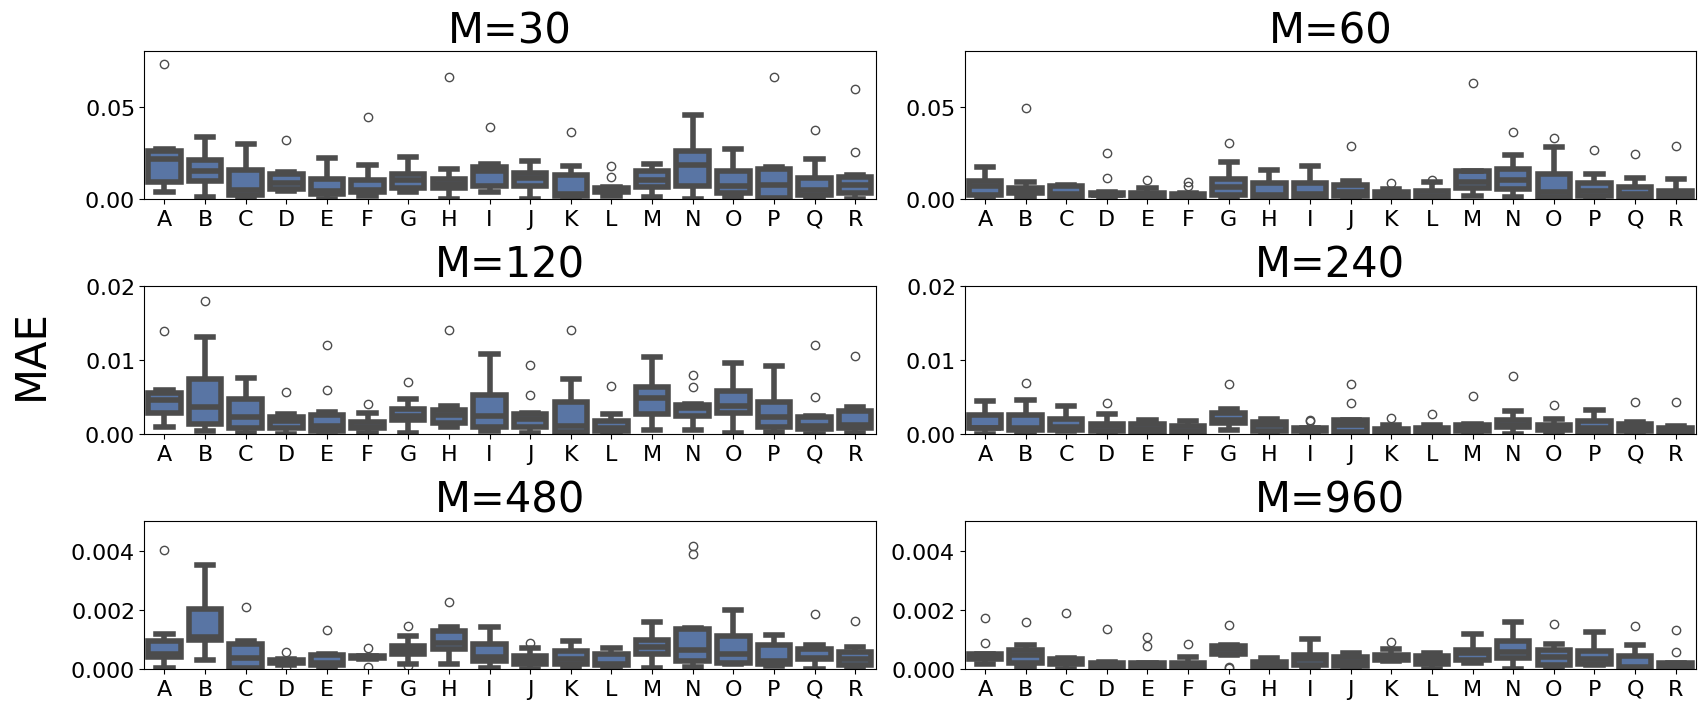

In [22]:
# combined boxplot
df_err = pd.read_pickle("ttl_clock_k3_errors.pkl")

thetas = [0.8, 1.1]
ks = [0, 1, 15]
workloads = ["IRM", "PH", "HE"]
pairs = list(itertools.product(workloads, ks, thetas))
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(pairs)])

sns.set_palette("deep")
font_axes = 30
font_ticks = 16
line_width = 4

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = pd.concat([
    df_err.assign(workload="IRM", k=df_err.k, theta=df_err.theta, abs_error=df_err.rel_error_irm),
    df_err.assign(workload="PH", k=df_err.k, theta=df_err.theta, abs_error=df_err.rel_error_ph),
    df_err.assign(workload="HE", k=df_err.k, theta=df_err.theta, abs_error=df_err.rel_error_he)
], ignore_index=True)

df_plot["method_param"] = list(zip(df_plot.workload, df_plot.k, df_plot.theta))
df_plot["label"] = df_plot["method_param"].map(mapping)
df_plot = df_plot.dropna(subset=["label", "abs_error"]).copy()

ms = [30, 60, 120, 240, 480, 960]
y_lims = {
    30: (0.00, 0.08),
    60: (0.00, 0.08),
    120: (0.00, 0.02),
    240: (0.00, 0.02),
    480: (0.00, 0.005),
    960: (0.00, 0.005),
}
subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, M in zip(axes_flat, ms):
    cell = df_plot[df_plot.m == M].copy()
    sns.boxplot(x="label", y="abs_error", data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.set_ylim(*y_lims[M])

fig2.text(0.025, 0.5, "MAE", va="center", rotation="vertical",
          fontsize=font_axes)
plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("figures/clock_k_all_mae.pdf", format="pdf")
plt.show()


In [ ]:
ks = [0, 1, 15, 255]
thetas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
cache_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
trace_len = 10_000_000
n_items = 1000
base_theta = 0.8
base_theta_idx = thetas.index(base_theta)

# irm_traces = [gen_from_zipf(n_items, trace_len, theta)[1].astype(np.int32) for theta in thetas]
# ph_traces = [gen_from_2ph(n_items, theta, trace_len).astype(np.int32) for theta in thetas]
# he_traces = [gen_from_he(n_items, theta, trace_len).astype(np.int32) for theta in thetas]

# run_c = lambda C, trc, K: tg.sim_clock(C, trc, raw=True, K=K) if K > 0 else tg.sim_fifo(C, trc, raw=True)

# C_theta = 300
# hr_vs_theta_irm = {k: [run_c(C_theta, trc, k) for trc in irm_traces] for k in ks}
# hr_vs_theta_ph = {k: [run_c(C_theta, trc, k) for trc in ph_traces] for k in ks}
# hr_vs_theta_he = {k: [run_c(C_theta, trc, k) for trc in he_traces] for k in ks}
# irm_base = irm_traces[base_theta_idx]
# ph_base = ph_traces[base_theta_idx]
# he_base = he_traces[base_theta_idx]
# hr_vs_C_irm = {k: [run_c(C, irm_base, k) for C in cache_sizes] for k in ks}
# hr_vs_C_ph = {k: [run_c(C, ph_base, k) for C in cache_sizes] for k in ks}
# hr_vs_C_he = {k: [run_c(C, he_base, k) for C in cache_sizes] for k in ks}

# np.savez_compressed('data/hr_vs_theta_cache.npz',
#                     hr_vs_theta_irm=hr_vs_theta_irm,
#                     hr_vs_theta_ph=hr_vs_theta_ph,
#                     hr_vs_theta_he=hr_vs_theta_he,
#                     hr_vs_C_irm=hr_vs_C_irm,
#                     hr_vs_C_ph=hr_vs_C_ph,
#                     hr_vs_C_he=hr_vs_C_he)

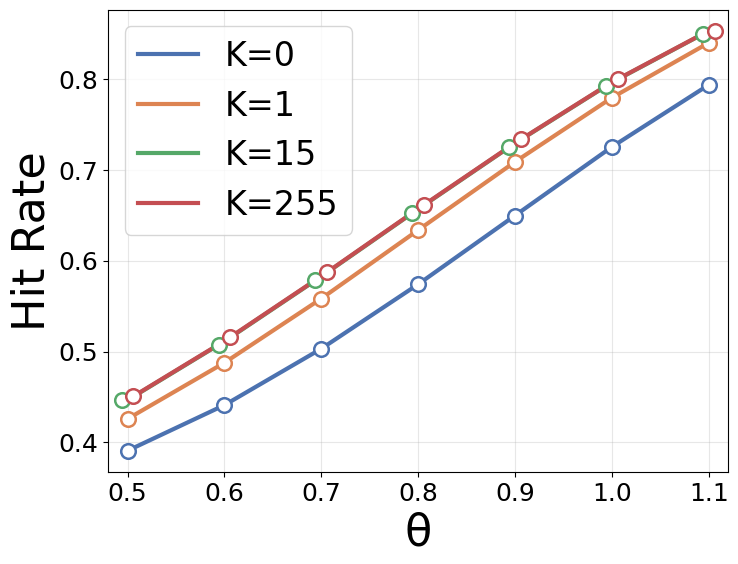

In [30]:
with np.load('data/hr_vs_theta_cache.npz', allow_pickle=True) as cache:
    def _unwrap(name):
        arr = cache[name]
        return arr.item() if arr.dtype == object and arr.shape == () else arr

    hr_vs_theta_irm = _unwrap('hr_vs_theta_irm')

ks_available = sorted(int(k) for k in hr_vs_theta_irm.keys())
preferred_order = [0, 1, 15, 25, 255]
ks = [k for k in preferred_order if k in ks_available] + [k for k in ks_available if k not in preferred_order]
colors = sns.color_palette('deep', len(ks))

series_len = len(np.asarray(next(iter(hr_vs_theta_irm.values())), dtype=np.float64))
if 'thetas' in globals() and len(thetas) == series_len:
    theta_arr = np.asarray(thetas, dtype=np.float64)
elif series_len == 7:
    theta_arr = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1], dtype=np.float64)
else:
    theta_arr = np.arange(series_len, dtype=np.float64)

theta_offsets = {k: 0.0 for k in ks}
if 15 in theta_offsets and 25 in theta_offsets:
    theta_offsets[15] = -0.006
    theta_offsets[25] = 0.006
elif 15 in theta_offsets and 255 in theta_offsets:
    theta_offsets[15] = -0.006
    theta_offsets[255] = 0.006

fig, ax = plt.subplots(1, 1, figsize=(8, 6), sharey=False)
handles = []
labels = []

for k, color in zip(ks, colors):
    y = np.asarray(hr_vs_theta_irm[k], dtype=np.float64)
    if y.size != theta_arr.size:
        x = np.linspace(theta_arr.min(), theta_arr.max(), y.size)
    else:
        x = theta_arr
    [line] = ax.plot(
        x,
        y,
        lw=3.0,
        color=color,
        linestyle='-',
        label=None,
    )

    x_mark = x + theta_offsets.get(k, 0.0)
    y_mark = np.interp(np.clip(x_mark, x.min(), x.max()), x, y)
    ax.scatter(
        x_mark,
        y_mark,
        s=110,
        marker='o',
        facecolors='white',
        edgecolors=color,
        linewidths=1.8,
        zorder=3,
    )

    handles.append(line)
    labels.append(f'K={k}')

ax.set_xlabel('θ', fontsize=32)
ax.set_ylabel('Hit Rate', fontsize=32)
ax.tick_params(axis='both', labelsize=18)
ax.grid(True, alpha=0.3)
ax.set_xlim(theta_arr.min() - 0.02, theta_arr.max() + 0.02)

ax.legend(
    handles,
    labels,
    loc='upper left',
    fontsize=24,
    frameon=True,
    handlelength=1.8,
    columnspacing=1.0,
)
plt.savefig('figures/c_k_irm.pdf', bbox_inches='tight', format='pdf')
plt.show()
